In [395]:
import tensorflow as tf

In [396]:




# Import Keras and other Deep Learning dependencies
from keras.models import Sequential
import time
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.utils.layer_utils import get_source_inputs
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import pickle
# from fr_utils import *
# from inception_blocks_v2 import *
import numpy.random as rng
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

# np.set_printoptions(threshold=np.nan)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [397]:
data_path = "data/"
train_folder = "training"
val_folder = "test"
default_class = "gesture"

In [398]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

/Users/tinydeltas/projects/cmsc730-project/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

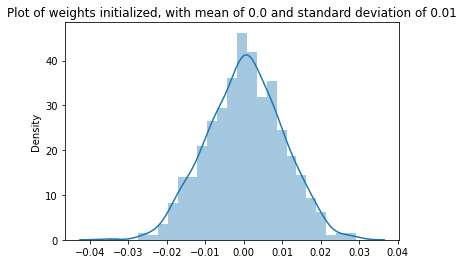

In [399]:
# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

In [400]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

/Users/tinydeltas/projects/cmsc730-project/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

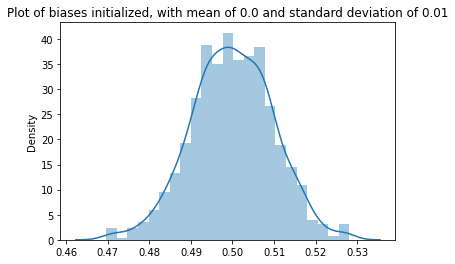

In [401]:
# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [402]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

def get_model(in_shape): 
    left = Input(in_shape)
    right = Input(in_shape)

    model = Sequential()
    model.add(Conv2D(64, 
        (10,10), 
    activation='relu', 
    input_shape=in_shape,
    kernel_initializer=initialize_weights, 
    kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_initializer=initialize_weights, bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights, bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights, bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid', kernel_regularizer=l2(1e-3), kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left)
    encoded_r = model(right)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    net = Model(inputs=[left, right], outputs=prediction)
    return net 

In [403]:
# update for acoustic data
model = get_model((100, 100, 3))
model.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
input_60 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
sequential_29 (Sequential)      (None, 4096)         27426112    input_59[0][0]                   
                                                                 input_60[0][0]                   
__________________________________________________________________________________________________
lambda_26 (Lambda)              (None, 4096)         0           sequential_29[0][0]       

In [404]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

/Users/tinydeltas/projects/cmsc730-project/venv/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [405]:
class Loader: 
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path+"/images/processed", name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        
        # (8, 8, 100, 100, 3)
        n_classes, n_examples, w, h, _ = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w, 3)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            
            idx_1 = rng.randint(0, n_examples)
            
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 3)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h, 3)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """
        Create pairs of test image, support set for testing N way one-shot learning. 
        """
        X=self.data[s]
        n_classes, n_examples, w, h, _ = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h, 3)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h, 3)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))

loader = Loader(data_path)

loading data from data//images/processed/train.pickle
loading data from data//images/processed/val.pickle


In [406]:
X=loader.data["train"]
print(X.shape)
X


(8, 8, 100, 100, 3)


array([[[[[  0,  33, 181],
          [  0,  35, 183],
          [ 21,  29, 177],
          ...,
          [134,  17, 163],
          [ 53,  25, 174],
          [ 71,  24, 171]],

         [[ 15,  30, 178],
          [  0,  36, 184],
          [  0,  37, 185],
          ...,
          [  0,  39, 186],
          [  0,  44, 190],
          [  0,  38, 186]],

         [[ 89,  22, 169],
          [  0,  37, 185],
          [  0,  38, 186],
          ...,
          [  0,  45, 191],
          [  0,  41, 188],
          [  0,  45, 191]],

         ...,

         [[  0, 163, 236],
          [  0, 157, 235],
          [  0, 152, 234],
          ...,
          [  0, 182, 241],
          [  0, 179, 240],
          [  0, 175, 239]],

         [[  0, 209, 246],
          [  0, 209, 246],
          [  0, 209, 246],
          ...,
          [  0, 204, 245],
          [  0, 202, 245],
          [  0, 197, 244]],

         [[  0, 175, 239],
          [  0, 177, 240],
          [  0, 179, 240],
         

In [407]:
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every = 10 # interval for printing loss (iterations)
batch_size = 2
n_iter = 1000
N_way = 8 # how many classes for testing one-shot tasks>
n_val = 7 # how many one-shot tasks to validate on?
best = -1

weights_path = os.path.join(data_path, "model_weights.h5")
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path))
            model.save_weights(weights_path)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration", i)
        print("training loss: ", loss)

        

model.load_weights(weights_path)

Starting training process!
-------------------------------------

 ------------- 

Loss: [3.3731861114501953, 0.5]

 ------------- 

Loss: [3.3597798347473145, 0.5]
Time for 2 iterations: 1.8883638381958008
Evaluating model on 7 random 8 way one-shot learning tasks ... 

Got an average of 14.285714285714286% 8 way one-shot learning accuracy 

Current best: 14.285714285714286, previous best: -1
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: [3.3524065017700195, 0.5]

 ------------- 

Loss: [3.317732810974121, 0.5]
Time for 4 iterations: 3.7334847450256348
Evaluating model on 7 random 8 way one-shot learning tasks ... 

Got an average of 42.857142857142854% 8 way one-shot learning accuracy 

Current best: 42.857142857142854, previous best: 14.285714285714286
Saving weights to: data/model_weights.h5 


 ------------- 

Loss: [3.3191590309143066, 0.5]

 ------------- 

Loss: [3.27704119682312, 0.5]
Time for 6 iterations: 5.590775966644287
Evaluating model on 7 random 8 

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 8, 1)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 20
for N in ways:
    val_accs.append(loader.test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N, trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()